<a href="https://colab.research.google.com/github/SiraDD/Monte-Carlo-Options/blob/main/LSTM_time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [31]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
import yfinance as yfin
yfin.pdr_override()

In [40]:
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=12000)
df = pdr.get_data_yahoo('MSFT', startDate, endDate)
df['Close']

[*********************100%***********************]  1 of 1 completed


Date
1990-03-29 00:00:00-05:00      0.767361
1990-03-30 00:00:00-05:00      0.769097
1990-04-02 00:00:00-04:00      0.774306
1990-04-03 00:00:00-04:00      0.805556
1990-04-04 00:00:00-04:00      0.812500
                                ...    
2023-01-30 00:00:00-05:00    242.710007
2023-01-31 00:00:00-05:00    247.809998
2023-02-01 00:00:00-05:00    252.750000
2023-02-02 00:00:00-05:00    264.600006
2023-02-03 00:00:00-05:00    258.350006
Name: Close, Length: 8277, dtype: float64

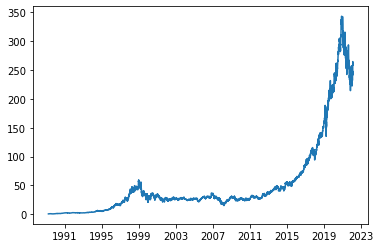

In [41]:
plt.plot(df.index,df['Close'])

In [35]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [32]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [43]:
windowed_df = df_to_windowed_df(df,
                             '1990-05-29',
                             '2023-02-23',
                             n=3)
windowed_df

<ipython-input-32-d663fab2a100>:12: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  df_subset = dataframe.loc[:target_date].tail(n+1)
<ipython-input-32-d663fab2a100>:25: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]


KeyboardInterrupt: ignored